In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct  7 17:11:35 2019

@author: User
"""
"""
H added up path lengths along the boundaries
he used expaning sphere method
worked with computer science student who did fast march algorithm
One overall goal was to find the triple phase boundary density
"
The microstructural parameters such as volume fractions,
: DO NOT need particle diameter as its own quantity:, active/inactive triple 
phase boundary, tortuosity; were calculated
for the as-reduced cell and cells after operations.
"
"""
print('')

In [2]:
# Package Import
from threshold import threshold           # File I created to threshold images
from scipy.io import loadmat              # loads .mat file
import matplotlib.pyplot as plt           # plots data: includes plot & imshow
from mpl_toolkits import mplot3d          # supports 3d plotting
import pandas as pd                       # easy to use 2D data structure
import numpy as np                        # contains a variety of numerical
                                          # methods and data structures
from collections import Counter           # structure that counts occurences
from smt.sampling_methods import LHS      # latin hypercube sampling function
import pyDOE as pydoe                     # contains sampling methods
import os                                 # interacts with PATH to find files
import time                               # used for timer function
import tqdm                               # progress bar for iterables
import re                                 # regex bayBEEE


# define target folder
path = 'C:\\Users\\User\\Documents\\SOFC_Data_Science\\Data_OG'

In [3]:
# Load files from path
# start timer
tic = time.time()
def load_files(path):
    """
    param: path: full path to the folder containing all data files
    return: loaded: dict of all files loaded, with keys equal to the
                    important part of the file names: format "PCT195-A2-Anode"
    return: filenames: list of full file paths for each file
    """
    filenames = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.mat' in file:
                filenames.append(os.path.join(r, file))

    print('files found: ')
    for f in filenames:
        print('.' + f[49:])

    # load all .mat files from target folder
    loaded={}
    for filename in filenames:
        fn = 'Amira_' + re.sub(r"[^\w\s\\:]", '_', filename)[50:]
        loaded.update({filename[50:-4] : loadmat(filename)[fn]})
    print(str(time.time()-tic) + ' seconds elapsed')
    return loaded, filenames
loaded,filenames = load_files(path)

files found: 
.\PCT195-A2-Anode.mat
.\PCt195-B1-Anode.mat
.\PCT195-B2-Anode-.mat
.\PCT209-1Khrs-anode.mat
.\PCT209-As-reduced-Anode.mat
1.7767860889434814 seconds elapsed


In [4]:
# this loads only the A2 anode file data, then thresholds layerone
onefile = loaded[filenames[0][50:-4]]
layerone = onefile[:,:,0] # extract first sheet of data from the matrix

x = threshold(layerone)

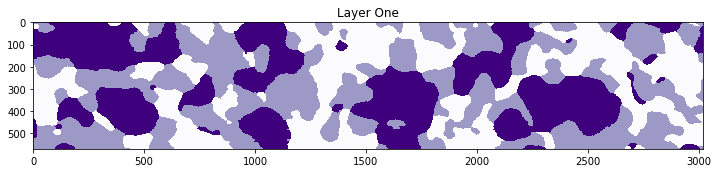

In [5]:
# Make Colormap
def make_colormap(data,title):
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(111)
    ax.set_title(title)
    plt.imshow(data,cmap='Purples')
    ax.set_aspect('equal')

    #plt.colorbar(orientation='horizontal')
    plt.show()
make_colormap(x,'Layer One')

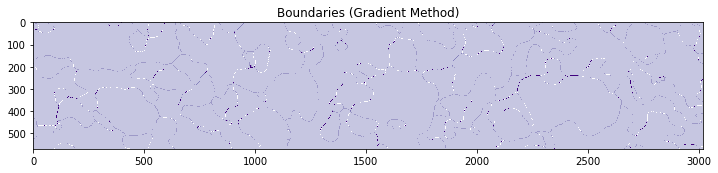

In [6]:
#Find phase boundaries
y = np.gradient(x)
z = 1/((y[0]+y[1])-0.75)
make_colormap(z, "Boundaries (Gradient Method)")

In [7]:
xlimits = np.array([ [0, onefile.shape[0]-1], [0, onefile.shape[1]-1], [0, onefile.shape[2]-1]])
sampling = LHS(xlimits=xlimits)

samps = sampling(int(2e5)) # control number of points generated
samps = np.round(samps,decimals=0).astype(int)
print(samps.shape)
fig3 = plt.figure(figsize=(4,20))
#ax = plt.axes(projection='3d')
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
#ax.view_init(60, 90)
#ax.invert_xaxis()
#ax.invert_yaxis()
#ax.scatter3D(x[:, 0], x[:, 1],x[:,2], ",", color='xkcd:plum');
#plt.show()

(200000, 3)


<Figure size 288x1440 with 0 Axes>

In [8]:
# find volume of three-phase boundaries divided by volume of entire thing
# focus on finding three phase boundaries specifically

In [9]:
def searchx(xin,yin,zin,matrix,direction):
    """
    param: xin: input x value for random point
    param: yin: input y value for random point
    param: zin: input z value for random point
    param: matrix: 3d input dataframe
    param: direction: must be 1 or -1: search east or west
    return: (xin,yin,zin): input coordinates
    return: (xin,yin+i,zin): output location of border
    return: (center,edgeval): change of phase
    """
    i = 0
    center = matrix[xin,yin,zin]
    edgeval = center
    # increment up until it finds northern border
    while edgeval == center and (xin+i > 0) and (xin+i < onefile.shape[0]):
        edgeval = matrix[xin+i,yin,zin]
        i+=direction

    return [(xin, yin, zin), (xin+i, yin, zin), (center,edgeval)]

In [10]:
def searchy(xin,yin,zin,matrix,direction):
    """
    param: xin: input x value for random point
    param: yin: input y value for random point
    param: zin: input z value for random point
    param: matrix: 3d input dataframe
    param: direction: must be 1 or -1: search north or south
    return: (xin,yin,zin): input coordinates
    return: (xin,yin+i,zin): output location of border
    return: (center,edgeval): change of phase
    """
    i = 0
    center = matrix[xin,yin,zin]
    edgeval = center
    # increment up until it finds northern border
    while edgeval == center and (yin+i > 0) and (yin+i < onefile.shape[1]):
        edgeval = matrix[xin,yin+i,zin]
        i+=direction

    return [(xin, yin, zin), (xin, yin+i, zin), (center,edgeval)]

In [11]:
def searchz(xin,yin,zin,matrix,direction):
    """
    param: xin: input x value for random point
    param: yin: input y value for random point
    param: zin: input z value for random point
    param: matrix: 3d input dataframe
    param: direction: must be 1 or -1: search in or out
    return: (xin,yin,zin): input coordinates
    return: (xin,yin,zin+i): output location of border
    return: (center,edgeval): change of phase
    """
    i = 0
    center = matrix[xin,yin,zin]
    edgeval = center
    # increment up until it finds northern border
    while edgeval == center and (zin+i > 0) and (zin+i < onefile.shape[2]):
        edgeval = matrix[xin,yin,zin+i]
        i+=direction

    return [(xin, yin, zin), (xin, yin, zin+i), (center,edgeval)]

In [14]:
timer = time.time()
borderdata = []
for [xpos,ypos,zpos] in tqdm.tqdm(samps):
    # run through the search algoriths (up and down) for each dimension)
    # currently runs in O(n) time, at 2000 operations per second
    borderdata.append(searchx(xpos,ypos,zpos,onefile,direction =  1))
    borderdata.append(searchx(xpos,ypos,zpos,onefile,direction = -1))
    borderdata.append(searchy(xpos,ypos,zpos,onefile,direction =  1))
    borderdata.append(searchy(xpos,ypos,zpos,onefile,direction = -1))
    borderdata.append(searchz(xpos,ypos,zpos,onefile,direction =  1))
    borderdata.append(searchz(xpos,ypos,zpos,onefile,direction = -1))
    
print('Time elapsed: ' + str(time.time()-timer) + ' seconds.')
print(str(samps.shape[0]) + ' points scanned.')

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [02:03<00:00, 1613.28it/s]


Time elapsed: 124.08541440963745 seconds.
200000 points scanned.


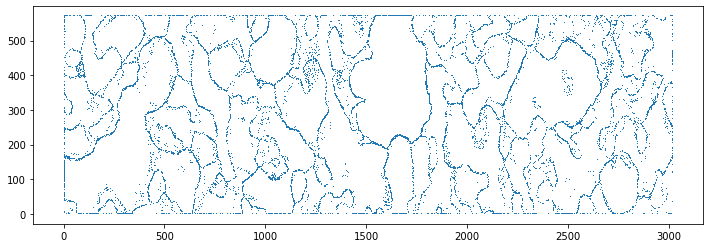

In [15]:
borders = [item[1] for item in borderdata] # just border locations
sliced = [item for item in borders if item[2]==1] # just second slice
# NOTE that where any dimension == 0 or max of that dimension, there will be a lot of noise
# plot the first slice
fig4 = plt.figure(figsize=(12,4))
# note that 1 and 0 below should be switched for accurate dimension
plt.plot([item[1] for item in sliced],
         [item[0] for item in sliced],
         marker=',',linestyle='')
#plt.gca().invert_yaxis()